# Giris
TensorFlow 2 tutorial üzerindeki çalışmamdan herkese merhaba. Bu çalışmada video verileri üzerinde çalışacağız ve UCF101 insan eylemi veri kümesini kullanarak AVI formatındaki video verilerinin nasıl yükleneceğini ve ön işlemeye tabi tutulacağını inceleyeceğiz.<br>
AVI video nedir?<br>
AVI (Audio Video Interleave), Microsoft tarafından 1992 yılında geliştirilmiş bir multimedya dosya formatıdır. AVI, hem ses hem de video verilerini aynı dosya içinde saklayarak, senkronize bir şekilde ses ve video oynatımı sağlar.
UCF101 Veri Kümesi Hakkında Bilgiler<br>
UCF101, insan hareketlerini tanımaya yönelik bir video veri kümesidir ve bilgisayarlı görü ve derin öğrenme alanında yaygın olarak kullanılmaktadır
- Veri kümesi, toplamda 13,320 video klip içerir.
- 101 farklı insan hareketi kategorisi barındırır. Bu kategoriler, spor aktiviteleri (ör. yüzme, futbol oynama), günlük hareketler (ör. yazı yazma, yürüme) ve daha karmaşık hareketleri (ör. jonglörlük, parkur) içerir.
- Videolar genellikle kısa kliplerdir ve AVI formatında sunulur.

In [1]:
# Kullanacagimiz kutuphaneleri indirelim.
!pip install -U "tensorflow>=2.10.0"
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
  Preparing metadata (setup.py) ... done


In [2]:
import tqdm
import random
import pathlib
import itertools
import collections
import os
import cv2
import numpy as np
import remotezip as rz
import tensorflow as tf

import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

# UCF101 veri kümesinin bir alt kümesini indirin
UCF101 veri kümesinin alt kümesini indireceğiz.

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

Yukarıdaki URL bir zip dosyasıdır ve bu dosyayı incelemek için 'remotezip' kütüphanesini kullanarak bir fonksiyon hazırlayacağız.

In [4]:
def list_files_to_load(zip_url):
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [5]:
files = list_files_to_load(URL)
files = [f for f in files if f.endswith('.avi')]
print(f'Files listesinin uzunlugu: {len(files)}')
files[:10]

Files listesinin uzunlugu: 13320


['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

Yukarıdaki çıktıda, toplam veri sayımızı ve bu verilerin sınıf isimleriyle birlikte hazırlanmış isimlerini görmekteyiz. Bundan sonraki işlemde, veri sınıflarını çıkaracak ve her veri sınıfı altında verileri birleştireceğiz. Bunun için iki fonksiyon oluşturacağız.

In [6]:
# Her sinif ismi alan fonksiyon
def get_class(fname):
  return fname.split('_')[-3]

def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [7]:
# Kac sinif kullanacagimiz ve sinif basina veri sayisini seciyoruz
NUM_CLASSES = 10 # kullanacagimiz sinif sayisi
FILES_PER_CLASS = 50 # Kullanacagimiz sinif basina veri sayisi

In [8]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [9]:
print(f'Toplam sinif sayimiz: {len(classes)}')

Toplam sinif sayimiz: 101


In [10]:
print('Toplam sinif sayimiz:', len(classes))
print('class[0] icerisindeki toplam video sayisi:', len(files_for_class[classes[0]]))

Toplam sinif sayimiz: 101
class[0] icerisindeki toplam video sayisi: 145


In [11]:
# Veri kümesinde bulunan sınıfların bir alt kümesini ve sınıf başına belirli sayıda dosyayı seçen select_subset_of_classes adlı yeni bir fonksiyon
def select_subset_of_classes(files_for_class, classes, files_per_class):
  files_subset = {}
  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [12]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys()) # Kullanacagimiz siniflarin isimlerinin listesi

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

Şimdi veri kümemizi indireceğiz, istediğimiz alt kümelere böleceğiz ve eğitim ile doğrulama veri kümelerini oluşturacağız.

In [13]:
# Zip dosyasının içeriğini zip URL'sinden indirin.
def download_from_zip(zip_url, to_dir, file_names):
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

Aşağıdaki fonksiyon, daha önce bir veri alt kümesine yerleştirilmemiş kalan verileri döndürür. Bu kalan verileri belirtilen bir sonraki veri alt kümesine yerleştirmenize olanak tanır.

In [14]:
def split_class_lists(files_for_class, count):
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]

  return split_files, remainder

In [15]:
# UCF101 veri setinin bir alt kümesini indirin ve bunları eğitim, doğrulama ve test gibi çeşitli parçalara bölün.
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  files = list_files_to_load(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Dosya adı yoksa bu öğeyi listeden kaldırın

  files_for_class = get_files_per_class(files)
  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])

  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ':')
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [16]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


100%|██████████| 300/300 [05:56<00:00,  1.19s/it]


val :


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


test :


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


In [17]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [18]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/train
./UCF101_subset/train/BasketballDunk
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g11_c02.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g23_c01.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g11_c04.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g22_c03.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g18_c01.avi
./UCF101_subset/train/BasketballDunk/UCF101
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g25_c01.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g07_c01.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g05_c03.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g12_c03.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g01_c04.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g24_c04.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g08_c01.avi
./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g14_c02.avi
./UCF101_subset/train/B

# Her video dosyasından kareler oluşturun
Bu bölümde videolardan kareler oluşturacağız.<br>
Not:
- Bellek ve hesaplama yükünü azaltmak için az sayıda kare seçin.
- Her videodan aynı sayıda kare seçin, bu da veri grupları üzerinde çalışmayı kolaylaştırır.

In [19]:
# Bu fonksiyon, görüntü (frame) verilerini belirtilen formata ve boyuta dönüştürmek için kullanılır.
def format_frames(frame, output_size):
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [20]:
# frames_from_video_file fonksiyonu videoları karelere böler, video dosyasından rastgele seçilmiş n karelik bir aralığı okur ve bunları bir NumPy dizisi olarak döndürür.
# Her kategori için mevcut her video dosyasından kareler oluşturur.
def frames_from_video_file(video_path, n_frame, output_size = (224, 224), frame_step = 15):
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frame - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frame - 1):
    for _ in range(frame_step):
      ret, frame = src.read()

    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)

    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

# Video verilerini görselleştirin
Bu bölümde verilerimi görselleştireceğiz. Frame'lere ayırdığımız verileri Wikimedia fonksiyonunu kullanarak görselleştireceğiz.<br>
Wikimedia nedir?<br>
Wikimedia, kullanıcıların içerik oluşturabileceği, düzenleyebileceği ve paylaşabileceği bir açık içerik platformları ağını ifade eder. Wikimedia Foundation tarafından yönetilen bu platformlar, özgür ve özgün bilgi paylaşımını teşvik eder. Wikimedia, özellikle bilgiye erişimi serbest bırakmayı ve paylaşılan içeriği dünya çapında herkesin kullanımına sunmayı amaçlar.

In [21]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  12.7M      0  0:00:04  0:00:04 --:--:-- 13.2M


In [22]:
video_path = "End_of_a_jam.ogv"

In [23]:
sample_video = frames_from_video_file(video_path, n_frame = 10)
sample_video.shape

(10, 224, 224, 3)

In [24]:
# Bu fonksiyon, verilen bir dizi görüntüyü birleştirip bir GIF animasyonuna dönüştürmek için kullanılır.
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps = 10)
  return embed.embed_file('./animation.gif')


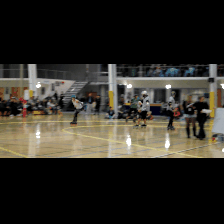

In [25]:
# 10 frameden olusan 224x224 gorutunun .GIF formattaki hali
to_gif(sample_video)


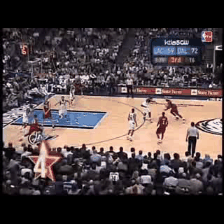

In [26]:
# ucf verilerinin icerisinden bir verinin gorselletirilmesi
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

Şimdi bir fonksiyon sistemi hazırlayacağız. Bu fonksiyon, videoyu frame'lere ayırarak sınıflara atayacak ve aynı zamanda, bu veri kümesiyle eğitim yapılacaksa verilerin karıştırma işlemini de gerçekleştirecek bir fonksiyon olacak.

In [27]:
class FrameGenerator:
  def __init__(self, path, n_frames, training =False):
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()
    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name]
      yield video_frames, label

In [28]:
fg = FrameGenerator(subset_paths['train'], 10, training = True)

frames, label = next(fg())

print(f'Shape: {frames.shape}')
print(f'Label: {label}')

Shape: (10, 224, 224, 3)
Label: 6


TensorFlow veri giriş hattı oluşturacağız Oluşturucu nesnesinden oluşturduğumuz bu boru hattı, derin öğrenme modelinize veri beslemenize olanak tanır. Bu video boru hattında, her bir öğe tek bir çerçeve kümesi ve ilişkili etiketidir.

In [29]:
output_signature = (
    tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['train'],
    10,
    training = True),
    output_signature = output_signature
)

In [30]:
# Etiketlerin karisitirildigini kontrol ediyoruz
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)


In [31]:
# Dogrulama(validation) kumesini olusuturuyoruz
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [32]:
# Egitim ve dogrulama veri kumelerinin boyutlari
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


# Veri setini performansa göre yapılandırın

In [33]:
# TensorFlow veri setlerini optimize ederek veri ön işleme sırasında daha hızlı ve verimli çalışmayı sağlar. İşte bu işlemlerin adım adım açıklaması:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [34]:
# TensorFlow veri seti üzerinde bir mini-batch işlem hattı oluşturur ve eğitim/validation veri kümelerinin şekillerini kontrol eder.
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')
# Eğer frame boyutları (n_frames, height, width, channels) = (10, 224, 224, 3) ve batch size 2

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [35]:
# Egitim
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
    150/Unknown 231s 1s/step - accuracy: 0.4957 - loss: 1.7622

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.4970 - loss: 1.7591 - val_accuracy: 0.9200 - val_loss: 0.5880
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9525 - loss: 0.4131 - val_accuracy: 0.9500 - val_loss: 0.3534
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9881 - loss: 0.2412 - val_accuracy: 0.9600 - val_loss: 0.2544
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9929 - loss: 0.1563 - val_accuracy: 0.9700 - val_loss: 0.1932
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9983 - loss: 0.1051 - val_accuracy: 0.9700 - val_loss: 0.1609
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 1.0000 - loss: 0.0924 - val_accuracy: 0.9800 - val_loss: 0.1368
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 1.0000 - loss: 0.0707 - val_accuracy: 0.9900 - val_loss: 0.1233
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 1.0000 - loss: 0.0508 - val_accuracy: 0.980

# Sonuc
TensorFlow 2 - Video bölümünün sonuna geldik. Arkadaşlar, bu çalışmadaki amacımız, video verilerini TensorFlow ile hazırlayıp model için optimize hale getirmekti ve kısa bir eğitim gerçekleştirdik. Eğitim üzerinde çok fazla açıklama yapmadım; nasıl yapıldığını gösterdim. Umarım çalışmam sizin için yararlı olmuştur. İyi günler, iyi çalışmalar dilerim.

Aşağıdaki Linklerden beni takip edebilir ve yapacağım çalışmalardan haberdar olabilirsiniz!<br>
[Linkedin](https://www.linkedin.com/in/ihsancenkiz/)<br>
[Github](https://github.com/ihsncnkz)<br>
[Kaggle](https://www.kaggle.com/ihsncnkz)